<h1>Processo seletivo para Estágio em Data Science</h1>

<h3>Vamos começar importar as bibliotecas que precisaremos e o dataframe </h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

<h3>Entendendo os dados</h3>

In [2]:
df = pd.read_csv('Safra_2018-2019.csv')
df = df.drop(['Unnamed: 0'], axis = 1)

In [3]:
df.describe()

,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,71945.000000,80000.000000,80000.000000,80000.000000
mean,1400.020875,0.283338,0.455550,2.267587,25.846750,28.664480,9.549088,1.897575,0.192312
std,849.792471,0.450622,0.498023,0.463748,15.557246,12.424751,9.905547,0.702079,0.455912
min,150.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,731.000000,0.000000,0.000000,2.000000,15.000000,20.000000,0.000000,1.000000,0.000000
50%,1212.000000,0.000000,0.000000,2.000000,20.000000,28.000000,7.000000,2.000000,0.000000
75%,1898.000000,1.000000,1.000000,3.000000,40.000000,37.000000,16.000000,2.000000,0.000000
max,4097.000000,1.000000,1.000000,3.000000,95.000000,67.000000,50.000000,3.000000,2.000000


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 10 columns):
Identificador_Agricultor    80000 non-null object
Estimativa_de_Insetos       80000 non-null int64
Tipo_de_Cultivo             80000 non-null int64
Tipo_de_Solo                80000 non-null int64
Categoria_Pesticida         80000 non-null int64
Doses_Semana                80000 non-null int64
Semanas_Utilizando          71945 non-null float64
Semanas_Sem_Uso             80000 non-null int64
Temporada                   80000 non-null int64
dano_na_plantacao           80000 non-null int64
dtypes: float64(1), int64(8), object(1)
memory usage: 6.1+ MB
None


<h2>Preprocessamento</h2>

<h5>Uma olhada superficial temos que há campos em Semanas_Utilizando que temos valores Nulos, mais de 10% do nosso dataset, um numero muito grande para simplesmente jogar fora</h5>

In [5]:
dfnan = df.isna()
p = len(dfnan.loc[dfnan['Semanas_Utilizando'] == True])/len(dfnan)
print("A porcentagem de valores faltando em Semanas_Utilizando", p)

A porcentagem de valores faltando em Semanas_Utilizando 0.1006875


In [6]:
def fill_nan_values(df):
    return df.fillna(df['Semanas_Utilizando'].mean())

Com isso, preenchemos o valor com a meida dos valores da coluna

In [7]:
df = fill_nan_values(df)

In [8]:
def dummies(df):
    df['Categoria_Pesticida'] = df['Categoria_Pesticida'].replace(1, 'Nunca Usou')
    df['Categoria_Pesticida'] = df['Categoria_Pesticida'].replace(2, 'Já Usou')
    df['Categoria_Pesticida'] = df['Categoria_Pesticida'].replace(3, 'Esta usando')
    df = pd.get_dummies(df, columns=['Categoria_Pesticida'])
    df = pd.get_dummies(df, columns=['Temporada'])
    return df

In [9]:
df = dummies(df)

<h4>Com isso atribuimos se o agricultor nunca usou, ja usou ou esta usando e transformamos em novas labels, ja que 1,2 ou 3 não é algo linear: Assim como a temporada</h4>

In [10]:
def feature_engineering(df):
    df['Semanas_Utilizando'] = df['Semanas_Utilizando'].astype(int)# Há um valor que não representa uma semana, ja que é um float
    df['Quant_total_de_Dose'] = (df['Semanas_Utilizando']*df['Doses_Semana']) #Assim temos noçao do quanto de dose o agricultor usou
    df['Total_de_Semanas'] = df['Semanas_Utilizando'] + df['Semanas_Sem_Uso']
    df['Razao_Uso'] = (df['Semanas_Utilizando']/df['Total_de_Semanas']).fillna(0) #Razao entre uso do pesticida ou não em semana, se foi 1:1 e etc
    s = np.zeros(len(df))
    for index in df.index:
        if df['Quant_total_de_Dose'][index] != 0:
            s[index] = df['Estimativa_de_Insetos'][index]/df['Quant_total_de_Dose'][index]
        else:
            s[index] = -1
    df['Razao_de_inseto_por_dose'] = s #Veremos se a quantidade de dose total é correspendente à quantidade de insetos estimada
    return df

In [11]:
df = feature_engineering(df)

In [12]:
df.describe()

,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,dano_na_plantacao,Categoria_Pesticida_Esta usando,Categoria_Pesticida_Já Usou,Categoria_Pesticida_Nunca Usou,Temporada_1,Temporada_2,Temporada_3,Quant_total_de_Dose,Total_de_Semanas,Razao_Uso,Razao_de_inseto_por_dose
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,1400.020875,0.283338,0.455550,25.846750,28.597575,9.549088,0.192312,0.277125,0.713337,0.009538,0.302912,0.496600,0.200488,760.685313,38.146662,0.757036,3.392703
std,849.792471,0.450622,0.498023,15.557246,11.784339,9.905547,0.455912,0.447582,0.452205,0.097194,0.459521,0.499992,0.400368,573.358734,11.741582,0.238095,5.376879
min,150.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,731.000000,0.000000,0.000000,15.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,330.000000,30.000000,0.581395,0.976190
50%,1212.000000,0.000000,0.000000,20.000000,28.000000,7.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,600.000000,39.000000,0.800000,1.886667
75%,1898.000000,1.000000,1.000000,40.000000,36.000000,16.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1040.000000,47.000000,1.000000,3.773333
max,4097.000000,1.000000,1.000000,95.000000,67.000000,50.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5510.000000,78.000000,1.000000,163.840000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 18 columns):
Identificador_Agricultor           80000 non-null object
Estimativa_de_Insetos              80000 non-null int64
Tipo_de_Cultivo                    80000 non-null int64
Tipo_de_Solo                       80000 non-null int64
Doses_Semana                       80000 non-null int64
Semanas_Utilizando                 80000 non-null int32
Semanas_Sem_Uso                    80000 non-null int64
dano_na_plantacao                  80000 non-null int64
Categoria_Pesticida_Esta usando    80000 non-null uint8
Categoria_Pesticida_Já Usou        80000 non-null uint8
Categoria_Pesticida_Nunca Usou     80000 non-null uint8
Temporada_1                        80000 non-null uint8
Temporada_2                        80000 non-null uint8
Temporada_3                        80000 non-null uint8
Quant_total_de_Dose                80000 non-null int64
Total_de_Semanas                   80000 non-null 

<h1>Escolhendo o modelo</h1>

<h2>Arrumando as nossas features, podemos começar a construir nosso modelo</h2>

In [14]:
from sklearn.model_selection import cross_val_score
y = df['dano_na_plantacao']
X = df.drop(['dano_na_plantacao', 'Identificador_Agricultor'], axis =1)

<h4>Para encontrarmos os melhores numeros de estimadores, vamos plotar possiveis candidatos a numero de estimador ou neighbor e encontrar o numero que melhor modela e depois comparar com uma rede neural</h4>

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow import keras

<h3>Random Forest Classifier</h3>

In [16]:
n_estimators = [5,10,15,20,30,50,100,200,300,400,500,750]
mean_score = []
for estim in n_estimators:
    clf = RandomForestClassifier(n_estimators=estim)
    scores = cross_val_score(clf, X, y, cv=5, n_jobs = -1, verbose = 1)
    mean_score.append(scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out

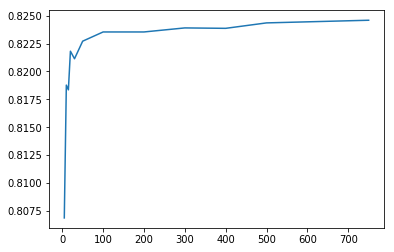

In [17]:
plt.plot(n_estimators ,mean_score)

<h3>Ada Boost Classifier</h3>

In [18]:
n_estimators = [5,10,15,20,30,50,100,200,300,400,750]
mean_score = []
for estim in n_estimators:
    clf = AdaBoostClassifier(n_estimators=estim)
    scores = cross_val_score(clf, X, y, cv=5, n_jobs = -1, verbose = 1)
    mean_score.append(scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out

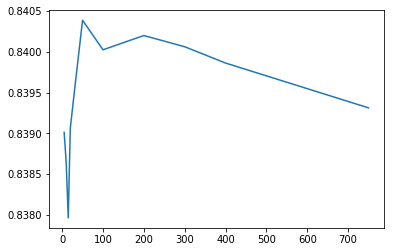

In [19]:
plt.plot(n_estimators ,mean_score)

<h3>KNN Classifier</h3>

In [20]:
n_estimators = [3,5,10,15,20,30,50,100, 200,300,500]
mean_score = []
for estim in n_estimators:
    clf = KNeighborsClassifier(n_neighbors=estim)
    scores = cross_val_score(clf, X, y, cv=5, n_jobs = -1, verbose = 1)
    mean_score.append(scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out

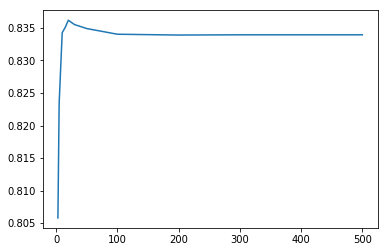

In [21]:
plt.plot(n_estimators ,mean_score)

<h3>Keras NN</h3>

In [22]:
def get_model():
    model = keras.Sequential([
    keras.layers.Dense(64, input_dim = 16, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy( threshold=0.6)])

    return model

In [23]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
y_nn = pd.get_dummies(y).values
X_nn = X.values
mean_score = []
for train_index,test_index in KFold(5,shuffle=True, random_state = 42).split(X_nn):
    x_train,x_test=X_nn[train_index],X_nn[test_index]
    y_train,y_test=y_nn[train_index],y_nn[test_index]
    dano0_test = y_test[:,0]
    dano1_test = y_test[:,1]
    dano2_test = y_test[:,2]
    model = get_model()
    model.fit(x_train, y_train, epochs=20)
    y_pred = model.predict(x_test)
    dano0_pred = [int(x > 0.6) for x in y_pred[:,0]]
    dano1_pred = [int(x > 0.6) for x in y_pred[:,1]]
    dano2_pred = [int(x > 0.6) for x in y_pred[:,2]]
    mean_score.append((accuracy_score(dano0_test, dano0_pred) + accuracy_score(dano1_test, dano1_pred) + accuracy_score(dano2_test, dano2_pred))/3)

Epoch 1/20
2000/2000 [==============================] - 1s 687us/step - loss: 1.7198 - binary_accuracy: 0.8874
Epoch 2/20
2000/2000 [==============================] - 1s 676us/step - loss: 1.7025 - binary_accuracy: 0.8890
Epoch 3/20
2000/2000 [==============================] - 1s 668us/step - loss: 1.7028 - binary_accuracy: 0.8889
Epoch 4/20
2000/2000 [==============================] - 1s 671us/step - loss: 1.7012 - binary_accuracy: 0.8890
Epoch 5/20
2000/2000 [==============================] - 1s 690us/step - loss: 1.7013 - binary_accuracy: 0.8890
Epoch 6/20
2000/2000 [==============================] - 1s 667us/step - loss: 1.7015 - binary_accuracy: 0.8890
Epoch 7/20
2000/2000 [==============================] - 1s 669us/step - loss: 1.7014 - binary_accuracy: 0.8890
Epoch 8/20
2000/2000 [==============================] - 1s 677us/step - loss: 1.7006 - binary_accuracy: 0.8891
Epoch 9/20
2000/2000 [==============================] - 1s 673us/step - loss: 1.6999 - binary_accuracy: 0.8890
E

2000/2000 [==============================] - 1s 684us/step - loss: 1.7040 - binary_accuracy: 0.8889
Epoch 15/20
2000/2000 [==============================] - 1s 693us/step - loss: 1.7041 - binary_accuracy: 0.8889
Epoch 16/20
2000/2000 [==============================] - 1s 684us/step - loss: 1.7038 - binary_accuracy: 0.8889
Epoch 17/20
2000/2000 [==============================] - 1s 692us/step - loss: 1.7034 - binary_accuracy: 0.8889
Epoch 18/20
2000/2000 [==============================] - 1s 685us/step - loss: 1.7033 - binary_accuracy: 0.8889
Epoch 19/20
2000/2000 [==============================] - 1s 682us/step - loss: 1.7037 - binary_accuracy: 0.8889
Epoch 20/20
2000/2000 [==============================] - 1s 690us/step - loss: 1.7036 - binary_accuracy: 0.8889
Epoch 1/20
2000/2000 [==============================] - 1s 672us/step - loss: 1.6460 - binary_accuracy: 0.8788
Epoch 2/20
2000/2000 [==============================] - 1s 680us/step - loss: 1.3739 - binary_accuracy: 0.8884
Epoch 

In [24]:
mean_score

[0.89025, 0.8885833333333334, 0.888375, 0.8908333333333333, 0.8884583333333333]

<h3>A rede neural perfomou bem melhor que os outros metodos</h3>

In [25]:
model = get_model()
model.fit(X_nn, y_nn, epochs=20)

Epoch 1/20
2500/2500 [==============================] - 2s 663us/step - loss: 1.0480 - binary_accuracy: 0.8817
Epoch 2/20
2500/2500 [==============================] - 2s 667us/step - loss: 0.3415 - binary_accuracy: 0.8886
Epoch 3/20
2500/2500 [==============================] - 2s 679us/step - loss: 0.3185 - binary_accuracy: 0.8889
Epoch 4/20
2500/2500 [==============================] - 2s 680us/step - loss: 0.3116 - binary_accuracy: 0.8877
Epoch 5/20
2500/2500 [==============================] - 2s 690us/step - loss: 0.3103 - binary_accuracy: 0.8882
Epoch 6/20
2500/2500 [==============================] - 2s 678us/step - loss: 0.3082 - binary_accuracy: 0.8883
Epoch 7/20
2500/2500 [==============================] - 2s 670us/step - loss: 0.3076 - binary_accuracy: 0.8884 1s - loss: 
Epoch 8/20
2500/2500 [==============================] - 2s 680us/step - loss: 0.3058 - binary_accuracy: 0.8888
Epoch 9/20
2500/2500 [==============================] - 2s 675us/step - loss: 0.3061 - binary_accura

In [65]:
def predict(df, model):
    X = df2020.drop(['Identificador_Agricultor'], axis=1).values
    y = model.predict(X)
    s =  np.zeros(len(y))
    for index in range(len(y)):
        if y[index][1] > y[index][2] and y[index][1] > y[index][0]:
            s[index] = 1
        elif y[index][2] > y[index][1] and y[index][2] > y[index][0]:
            s[index] = 2
    return s

<h2>Prevendo para casos em 2020</h2>

In [26]:
df2020 = pd.read_csv('Safra_2020.csv').drop(['Unnamed: 0'], axis = 1)

In [32]:
df2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8858 entries, 0 to 8857
Data columns (total 17 columns):
Identificador_Agricultor           8858 non-null object
Estimativa_de_Insetos              8858 non-null int64
Tipo_de_Cultivo                    8858 non-null int64
Tipo_de_Solo                       8858 non-null int64
Doses_Semana                       8858 non-null int64
Semanas_Utilizando                 8858 non-null int32
Semanas_Sem_Uso                    8858 non-null int64
Categoria_Pesticida_Esta usando    8858 non-null uint8
Categoria_Pesticida_Já Usou        8858 non-null uint8
Categoria_Pesticida_Nunca Usou     8858 non-null uint8
Temporada_1                        8858 non-null uint8
Temporada_2                        8858 non-null uint8
Temporada_3                        8858 non-null uint8
Quant_total_de_Dose                8858 non-null int64
Total_de_Semanas                   8858 non-null int64
Razao_Uso                          8858 non-null float64
Razao_de_i

In [28]:
df2020 = fill_nan_values(df2020)

In [29]:
df2020 = dummies(df2020)

In [30]:
df2020 = feature_engineering(df2020)

<h3>Essa é o dataframe dos agricultores em 2020</h3>

In [80]:
dfpredict = pd.DataFrame(predict(df2020, model), columns = ['dano_previsto'])

In [81]:
dfpredict

,dano_previsto
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
8853,0.0
8854,0.0
8855,0.0
8856,0.0


In [83]:
predict(df2020, model)

array([0., 0., 0., ..., 0., 0., 0.])